In [4]:
!pip install tf-keras-vis -q

In [8]:
import albumentations as alb
import tensorflow as tf
from functools import partial
import cv2
import numpy as np
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import keras_tuner
from utils import get_base_transforms, get_tf_dataset, get_train_transforms, plot_fine, plot_model

In [9]:
print(tf.__version__)

2.9.2


In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Data Inspection

In [13]:
def count_data(path):
    # Pfad zum Hauptverzeichnis
    root_dir = path

    # Liste der Unterverzeichnisse
    sub_dirs = os.listdir(root_dir)

    # Schleife über jedes Unterverzeichnis
    for sub_dir in sub_dirs:
        # Pfad zum aktuellen Unterverzeichnis
        dir_path = os.path.join(root_dir, sub_dir)
        files = os.listdir(dir_path)
        num_files = len(files)
        print(f"Anzahl der Dateien in {sub_dir}: {num_files}")

In [14]:
count_data("train")

Anzahl der Dateien in fake: 35749
Anzahl der Dateien in real: 35429


In [15]:
count_data("val")

Anzahl der Dateien in fake: 4814
Anzahl der Dateien in real: 4814


Loading Data

In [17]:
class_names = ["fake", "real"]

In [18]:
aug_xc = get_train_transforms(img_size=229, p=1.0)
base_aug_xc = get_base_transforms(img_size=229)

train_dataset_xc = get_tf_dataset(
    "train",
    aug_xc
)
val_dataset_xc = get_tf_dataset(
    "val",
    base_aug_xc,
    shuffle=False
)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Found 71178 files belonging to 2 classes.
Found 9628 files belonging to 2 classes.


In [24]:
aug_en = get_train_transforms(img_size=224, p=1.0)
base_aug_en = get_base_transforms(img_size=224)

train_dataset_en = get_tf_dataset(
    "train",
    aug_en
)
val_dataset_en = get_tf_dataset(
    "val",
    base_aug_en,
    shuffle=False
)

Found 71178 files belonging to 2 classes.
Found 9628 files belonging to 2 classes.


In [19]:
aug_vgg = get_train_transforms(img_size=224, p=1.0)
base_aug_vgg = get_base_transforms(img_size=224)

train_dataset_vgg = get_tf_dataset(
    "train",
    aug_vgg,
)
val_dataset_vgg = get_tf_dataset(
    "val",
    base_aug_vgg,
    shuffle=False
)

Found 71178 files belonging to 2 classes.
Found 9628 files belonging to 2 classes.


In [14]:
print(f"Number of train_batches: {tf.data.experimental.cardinality(train_dataset_vgg).numpy()}")
print(f"Number of val_batches: {tf.data.experimental.cardinality(val_dataset_vgg).numpy()}")

Number of train_batches: 2225
Number of val_batches: 301


In [17]:
for image_batch, labels_batch in train_dataset_vgg:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


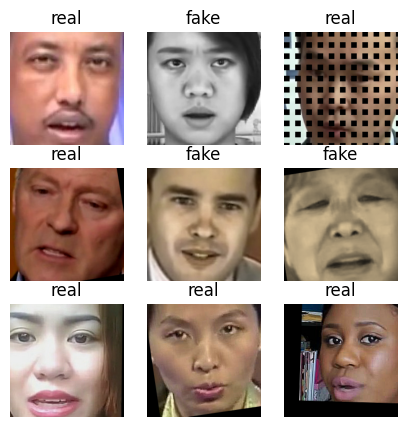

In [21]:
plt.figure(figsize=(5, 5))
for images, labels in train_dataset_vgg.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
    plt.axis("off")

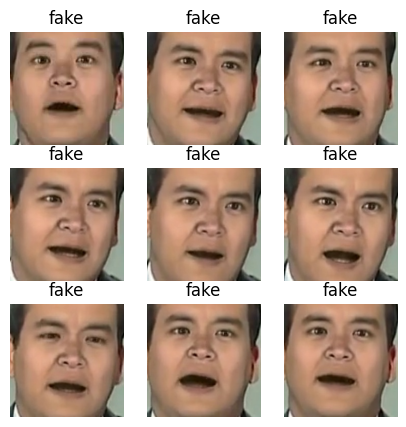

In [23]:
plt.figure(figsize=(5, 5))
for images, labels in val_dataset_vgg.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
    plt.axis("off")

Hyperparams:
* Optimizer Adam/SGD
* LR 10 - 3, momentum of 0.9, weight decay of 10−5 , lr 10-5, decay 5-5, decay 1e-4
* loss Function Binary Cross Entropy
* Metrics Accuracy
* Activation Sigmoid
* Epochs 10, 20, 32
* img size

* A. Raza, K. Munir, und M. Almutairi, „A Novel Deep Learning Approach for Deepfake Image Detection“, Applied Sciences, Bd. 12, Nr. 19, S. 9820, Sep. 2022, doi: 10.3390/app12199820.
* Z. Xia, T. Qiao, M. Xu, X. Wu, L. Han, und Y. Chen, „Deepfake Video Detection Based on MesoNet with Preprocessing Module“, Symmetry, Bd. 14, Nr. 5, S. 939, Mai 2022, doi: 10.3390/sym14050939.
* S. S. Khalil, S. M. Youssef, und S. N. Saleh, „iCaps-Dfake: An Integrated Capsule-Based Model for Deepfake Image and Video Detection“, Future Internet, Bd. 13, Nr. 4, S. 93, Apr. 2021, doi: 10.3390/fi13040093.





In [20]:
current_dir = os.getcwd()
checkpoint_filepath = current_dir+'/tmp_checkpoint'
if not os.path.exists(checkpoint_filepath):
    print('Creating Directory: ' + checkpoint_filepath)
    os.makedirs(checkpoint_filepath)
    
def get_callbacks(model_name=None):
    name = f"best_{model_name}.h5"
    custom_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            mode = 'min',
            patience = 5,
            verbose = 1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = os.path.join(checkpoint_filepath, name),
            monitor = 'val_loss',
            mode = 'min',
            verbose = 1,
            save_best_only = True
        )
    ]
    return custom_callbacks


EfficientNet V2

LR, Decay, Optimizer von

* L. Deng, H. Suo, und D. Li, „Deepfake Video Detection Based on EfficientNet-V2 Network“, Computational Intelligence and Neuroscience, Bd. 2022, S. 1–13, Apr. 2022, doi: 10.1155/2022/3441549.
* L. Guarnera u. a., „The Face Deepfake Detection Challenge“, J. Imaging, Bd. 8, Nr. 10, S. 263, Sep. 2022, doi: 10.3390/jimaging8100263.


In [11]:
def create_model_efficient_net(lr, decay):
    # Laden des EfficientNetV2-Modells (ohne den fully connected layer am Ende)
    base_model = keras.applications.EfficientNetV2S(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3),
                                                    include_preprocessing= False)

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    x = base_model(x, training=False)
    
     #hinzufügen des klassifikations layers
    x = tf.keras.layers.Conv2D(1025, 1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1025, activation='relu')(x)
    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="EfficientNetV2-S")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

In [12]:
base_learning_rate = 1e-2 # oder 1e-3 1e-4
decay = 1e-2
base_model, model = create_model_efficient_net(base_learning_rate, decay)
model.summary()

82420632/82420632 [==============================] - 1s 0us/step
Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1025)        1313025   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1025)       0         
 )                                                               
                                                   

In [ ]:
base_model.summary()

Transferlearning

In [13]:
loss0, accuracy0 = model.evaluate(val_dataset_en)

301/301 [==============================] - 43s 110ms/step - loss: 0.7579 - accuracy: 0.4612


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.46


In [15]:
initial_epochs = 10 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history = model.fit(train_dataset_en,
                    epochs=initial_epochs,
                    validation_data=val_dataset_en,
                   callbacks=callback[0])

Epoch 1/10
2225/2225 [==============================] - 303s 130ms/step - loss: 0.1869 - accuracy: 0.9177 - val_loss: 0.0686 - val_accuracy: 0.9822
Epoch 2/10
2225/2225 [==============================] - 297s 133ms/step - loss: 0.1237 - accuracy: 0.9473 - val_loss: 0.0638 - val_accuracy: 0.9816
Epoch 3/10
2225/2225 [==============================] - 287s 129ms/step - loss: 0.1157 - accuracy: 0.9511 - val_loss: 0.0613 - val_accuracy: 0.9844
Epoch 4/10
2225/2225 [==============================] - 286s 128ms/step - loss: 0.1122 - accuracy: 0.9544 - val_loss: 0.0622 - val_accuracy: 0.9828
Epoch 5/10
2225/2225 [==============================] - 284s 128ms/step - loss: 0.1062 - accuracy: 0.9553 - val_loss: 0.0602 - val_accuracy: 0.9849
Epoch 6/10
2225/2225 [==============================] - 292s 130ms/step - loss: 0.1040 - accuracy: 0.9565 - val_loss: 0.0599 - val_accuracy: 0.9849
Epoch 7/10
2225/2225 [==============================] - 295s 132ms/step - loss: 0.1017 - accuracy: 0.9585 - val_

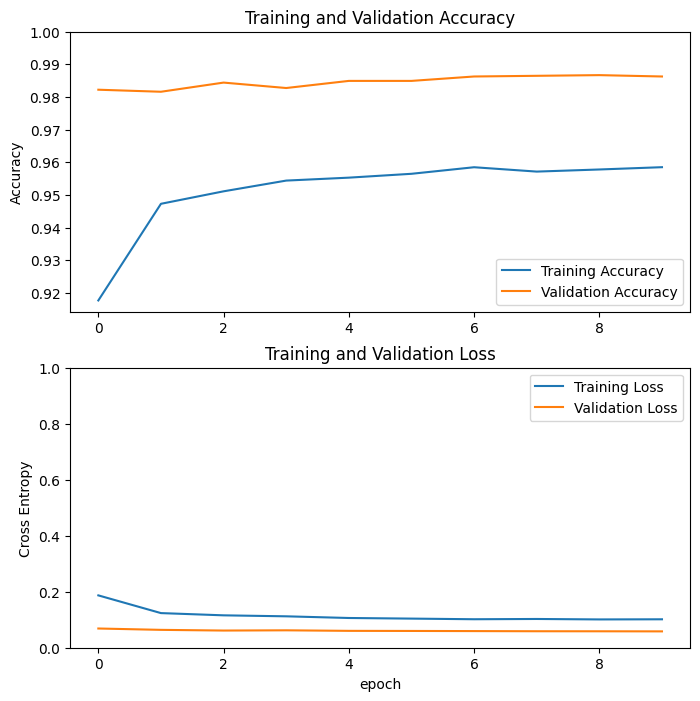

In [16]:
plot_model(history)

Architektur 2

In [13]:
def create_model_efficient_net(lr, decay):
    # Laden des EfficientNetV2-Modells (ohne den fully connected layer am Ende)
    base_model = keras.applications.EfficientNetV2S(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3),
                                                    include_preprocessing= False)

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    x = base_model(x, training=False)

    #hinzufügen des klassifikations layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    
    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="EfficientNetV2-S")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

base_learning_rate = 1e-2 # oder 1e-3 1e-4
decay = 1e-2
base_model, model = create_model_efficient_net(base_learning_rate, decay)
model.summary()

Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)         

In [14]:
initial_epochs = 5 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history = model.fit(train_dataset_en,
                    epochs=initial_epochs,
                    validation_data=val_dataset_en,
                   callbacks=callback[0])

Epoch 1/5
2225/2225 [==============================] - 297s 124ms/step - loss: 0.4875 - accuracy: 0.7445 - val_loss: 0.3489 - val_accuracy: 0.7950
Epoch 2/5
2225/2225 [==============================] - 276s 124ms/step - loss: 0.4579 - accuracy: 0.7657 - val_loss: 0.3377 - val_accuracy: 0.8029
Epoch 3/5
2225/2225 [==============================] - 276s 124ms/step - loss: 0.4538 - accuracy: 0.7694 - val_loss: 0.3344 - val_accuracy: 0.8031
Epoch 4/5
2225/2225 [==============================] - 275s 123ms/step - loss: 0.4463 - accuracy: 0.7746 - val_loss: 0.3304 - val_accuracy: 0.8055
Epoch 5/5
2225/2225 [==============================] - 271s 121ms/step - loss: 0.4460 - accuracy: 0.7750 - val_loss: 0.3324 - val_accuracy: 0.8021


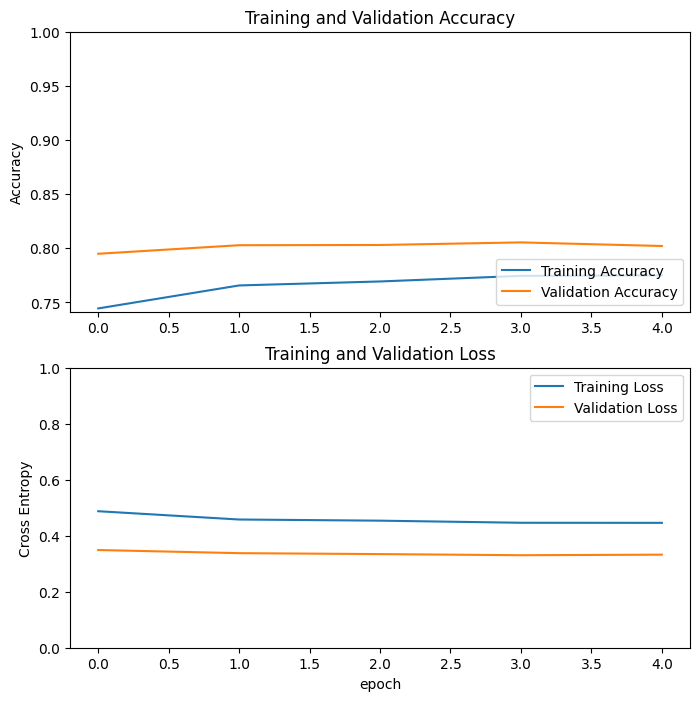

In [15]:
plot_model(history)

Finetuning

In [27]:
def unfreeze_model(model, lr, decay):
    print("Number of layers in the base model: ", len(base_model.layers))
    model.trainable = True
    set_trainable = False

    for layer in model.layers:
      if layer.name == 'block6j_expand_conv': ##block6a_expand_conv, block6d_se_excite
          set_trainable = True
      if set_trainable:
          if not isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False
      else:
          layer.trainable = False

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [28]:
finetune_lr = 10 #@param {type:"slider", min:0, max:10000, step:100}
unfreeze_model(base_model, base_learning_rate/finetune_lr, decay)

model.summary()

Number of layers in the base model:  512
Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1025)        1313025   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1025)       0         
 )                                                               
                                                                 
 dropout 

In [29]:
finetune_epochs = 20 # @param {type: "slider", min:1, max:30}
callback = get_callbacks("en")
history_fine = model.fit(train_dataset_en,
                    epochs=initial_epochs+finetune_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_dataset_en,
                    callbacks = callback)

Epoch 10/30
2224/2225 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.9585
Epoch 10: val_loss improved from inf to 0.05810, saving model to /notebooks/tmp_checkpoint/best_en.h5
2225/2225 [==============================] - 292s 131ms/step - loss: 0.1000 - accuracy: 0.9585 - val_loss: 0.0581 - val_accuracy: 0.9862
Epoch 11/30
2225/2225 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9582
Epoch 11: val_loss improved from 0.05810 to 0.05761, saving model to /notebooks/tmp_checkpoint/best_en.h5
2225/2225 [==============================] - 300s 134ms/step - loss: 0.0995 - accuracy: 0.9582 - val_loss: 0.0576 - val_accuracy: 0.9866
Epoch 12/30
2224/2225 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9604
Epoch 12: val_loss improved from 0.05761 to 0.05748, saving model to /notebooks/tmp_checkpoint/best_en.h5
2225/2225 [==============================] - 300s 134ms/step - loss: 0.0977 - accuracy: 0.9604 - val_loss: 0.0575 -

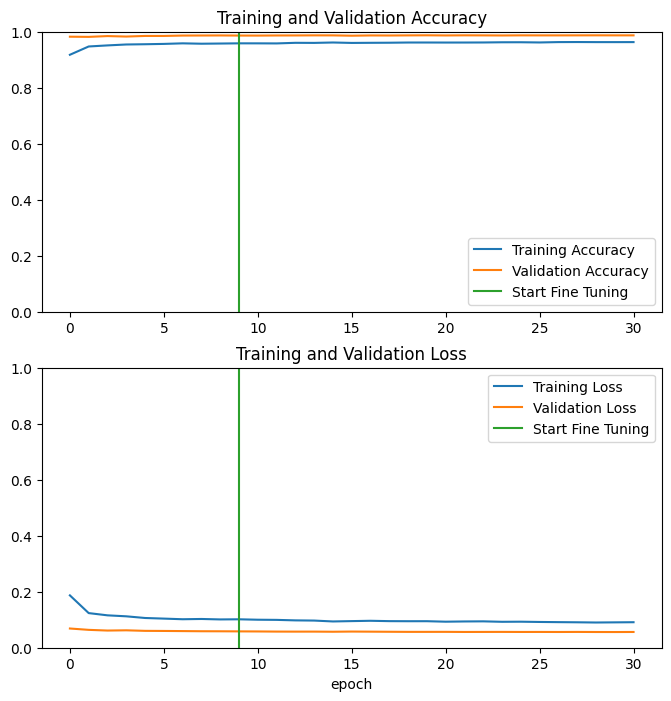

In [30]:
acc, val_acc, loss, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']
plot_fine(history_fine, acc, val_acc, loss, val_loss)

Hyperparam Optimierung

In [12]:
def create_model_efficient_net_hp(hp):
    # Laden des EfficientNetV2-Modells (ohne den fully connected layer am Ende)
    base_model = keras.applications.EfficientNetV2S(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3),
                                                    include_preprocessing=False)

    # Das gesamte Modell als trainierbar festlegen
    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    x = base_model(x, training=False)

    # Hyperparameter: Entscheidung, ob beide Dropout-Layer oder nur ein Dropout-Layer hinzugefügt werden sollen
    dropout_rate = hp.Choice('dropout_rate1', [0.2, 0.5])
    dropout_case = hp.Choice('dropout_case', ['both_dropout', 'dropout_after_pool', 'dropout_after_dense'])

    if dropout_case == 'add_both_dropout':
        # Hyperparameter: Dropout-Raten für beide Dropout-Layer
        x = tf.keras.layers.Conv2D(hp.Choice('num_filters', [500, 1500]), 1, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(hp.Choice('num_neurons', [500, 1500]), activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout Layer zur Regularisierung hinzufügen
    elif dropout_case == 'add_dropout_after_pool':
        # Hyperparameter: Dropout-Rate für den Dropout-Layer nach dem Pooling
        x = tf.keras.layers.Conv2D(hp.Choice('num_filters', [500, 1500]), 1, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(hp.Choice('num_neurons', [500, 1500]), activation='relu')(x)
    elif dropout_case == 'add_dropout_after_dense':
        # Hyperparameter: Dropout-Rate für den Dropout-Layer nach der Dense-Schicht
        x = tf.keras.layers.Conv2D(hp.Choice('num_filters', [500, 1500]), 1, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(hp.Choice('num_neurons', [500, 1500]), activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout Layer zur Regularisierung hinzufügen
    else:
        # Kein Dropout-Layer hinzufügen
        x = tf.keras.layers.Conv2D(hp.Choice('num_filters', [500, 1500]), 1, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(hp.Choice('num_neurons', [500, 1500]), activation='relu')(x)

    # Ausgabe-Layer mit einer einzelnen Neuronen für die binäre Klassifikation
    predictions = tf.keras.layers.Dense(1)(x)

    # Hyperparameter: Auswahl des Optimierers zwischen Adam und SGD
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])

    # Hyperparameter: Lernrate und Gewichtszerfall für den SGD-Optimierer
    if optimizer_choice == 'adam':
        lr = hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])
        decay = hp.Choice('weight_decay', [1e-2, 1e-4, 1e-5])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)
    else:
        lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        decay = hp.Choice('weight_decay', [1e-2, 1e-3, 1e-4])
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay)

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="EfficientNetV2-S")

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=["accuracy"])

    return model


In [13]:
hp_model_en = create_model_efficient_net_hp(keras_tuner.HyperParameters())
hp_model_en.summary()

82420632/82420632 [==============================] - 2s 0us/step
Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 500)         640500    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 500)        0         
 )                                                               
                                                   

In [14]:
tuner = keras_tuner.RandomSearch(
    hypermodel=create_model_efficient_net_hp,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="hp_op",
)
tuner.search(
    train_dataset_en,
    validation_data=val_dataset_en,
    epochs=3,
    callbacks=[tf.keras.callbacks.TensorBoard("tb_logs")],
)

# best hp
best_hps=tuner.get_best_hyperparameters()[0].values
best_model = tuner.get_best_models(num_models=1)[0]
print("Best Hyper Param")
print(best_hps)
print()
print("Best Model")
print(best_model.summary())

Trial 10 Complete [00h 30m 46s]
val_loss: 0.06666728295385838

Best val_loss So Far: 0.04961727000772953
Total elapsed time: 05h 13m 13s
INFO:tensorflow:Oracle triggered exit
Best Hyper Param
{'dropout_rate1': 0.2, 'dropout_case': 'both_dropout', 'num_filters': 500, 'num_neurons': 500, 'optimizer': 'adam', 'learning_rate': 0.001, 'weight_decay': 1e-05}

Best Model
Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv

Xception

Initialwerte Optimizer, LR, LR-Finetuning aus:
* A. Mitra, S. P. Mohanty, P. Corcoran, und E. Kougianos, „A Machine Learning Based Approach for Deepfake Detection in Social Media Through Key Video Frame Extraction“, SN COMPUT. SCI., Bd. 2, Nr. 2, S. 98, Apr. 2021, doi: 10.1007/s42979-021-00495-x.
* A. Khormali und J.-S. Yuan, „ADD: Attention-Based DeepFake Detection Approach“, BDCC, Bd. 5, Nr. 4, S. 49, Sep. 2021, doi: 10.3390/bdcc5040049.



In [53]:
def create_model_xception_net(lr, decay):
    # Laden des Xception-Models (ohne den fully connected layer am Ende)
    base_model = tf.keras.applications.Xception(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(229, 229, 3))

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(229, 229, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    # training = False damit beim finetuning die batchnorm layers nicht geupdated werden
    x = base_model(x, training=False)

    #hinzufügen des klassifikations layers
    #x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    #x = tf.keras.layers.Dense(1024, activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.5) (x)
    
     #hinzufügen des klassifikations layers
    x = tf.keras.layers.Conv2D(1025, 1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1025, activation='relu')(x)

    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="Xception")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

In [54]:
base_learning_rate = 10e-3 #oder 5e-4
decay = 10e-4
base_model, model = create_model_xception_net(base_learning_rate, decay)
model.summary()

83683744/83683744 [==============================] - 2s 0us/step
Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 1025)        2100225   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 1025)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 1025)        0   

Transferlearning

In [55]:
loss0, accuracy0 = model.evaluate(val_dataset_xc)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

301/301 [==============================] - 39s 119ms/step - loss: 0.6977 - accuracy: 0.5031
initial loss: 0.70
initial accuracy: 0.50


In [56]:
initial_epochs = 10 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history = model.fit(train_dataset_xc,
                    epochs=initial_epochs,
                    validation_data=val_dataset_xc,
                   callbacks=callback[0])

Epoch 1/10
2225/2225 [==============================] - 350s 155ms/step - loss: 0.3524 - accuracy: 0.8275 - val_loss: 0.2333 - val_accuracy: 0.8935
Epoch 2/10
2225/2225 [==============================] - 356s 160ms/step - loss: 0.2532 - accuracy: 0.8851 - val_loss: 0.1679 - val_accuracy: 0.9317
Epoch 3/10
2225/2225 [==============================] - 335s 150ms/step - loss: 0.2265 - accuracy: 0.8975 - val_loss: 0.1693 - val_accuracy: 0.9286
Epoch 4/10
2225/2225 [==============================] - 324s 145ms/step - loss: 0.2064 - accuracy: 0.9089 - val_loss: 0.1668 - val_accuracy: 0.9360
Epoch 5/10
2225/2225 [==============================] - 321s 144ms/step - loss: 0.1959 - accuracy: 0.9134 - val_loss: 0.1598 - val_accuracy: 0.9374
Epoch 6/10
2225/2225 [==============================] - 331s 148ms/step - loss: 0.1891 - accuracy: 0.9174 - val_loss: 0.1539 - val_accuracy: 0.9376
Epoch 7/10
2225/2225 [==============================] - 332s 149ms/step - loss: 0.1807 - accuracy: 0.9216 - val_

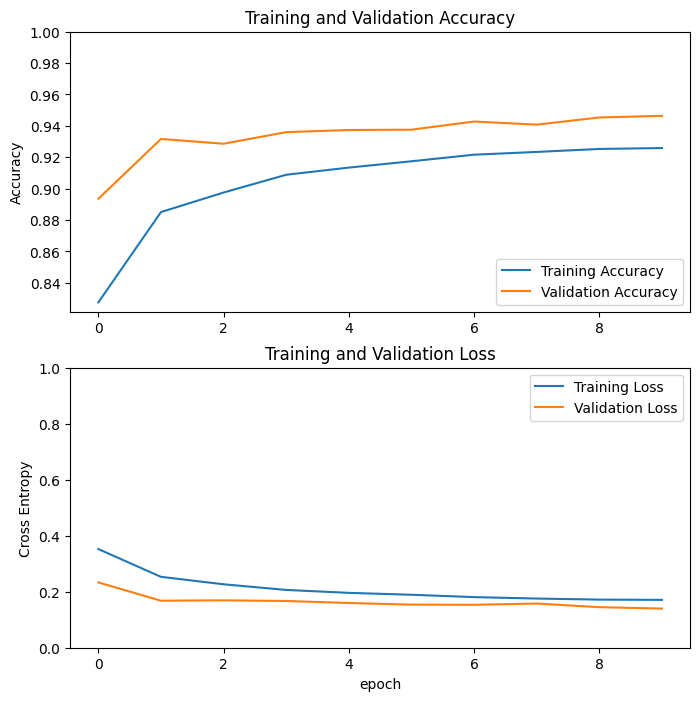

In [57]:
plot_model(history)

Architektur 2

In [22]:
def create_model_xception_net_2(lr, decay):
    # Laden des Xception-Models (ohne den fully connected layer am Ende)
    base_model = tf.keras.applications.Xception(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(229, 229, 3))

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(229, 229, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    # training = False damit beim finetuning die batchnorm layers nicht geupdated werden
    x = base_model(x, training=False)

    #hinzufügen des klassifikations layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5) (x)

    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="Xception")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

base_learning_rate = 10e-3 #oder 5e-4
decay = 10e-4
base_model_2, model_2 = create_model_xception_net_2(base_learning_rate, decay)
model_2.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                          

In [23]:
initial_epochs = 5 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history_2 = model_2.fit(train_dataset_xc,
                    epochs=initial_epochs,
                    validation_data=val_dataset_xc,
                   callbacks=callback[0])

Epoch 1/5
2225/2225 [==============================] - 317s 137ms/step - loss: 0.5358 - accuracy: 0.7072 - val_loss: 0.3624 - val_accuracy: 0.8035
Epoch 2/5
2225/2225 [==============================] - 310s 139ms/step - loss: 0.4965 - accuracy: 0.7346 - val_loss: 0.3420 - val_accuracy: 0.8173
Epoch 3/5
2225/2225 [==============================] - 303s 136ms/step - loss: 0.4818 - accuracy: 0.7454 - val_loss: 0.3464 - val_accuracy: 0.8054
Epoch 4/5
2225/2225 [==============================] - 302s 136ms/step - loss: 0.4775 - accuracy: 0.7497 - val_loss: 0.3501 - val_accuracy: 0.7912
Epoch 5/5
2225/2225 [==============================] - 303s 136ms/step - loss: 0.4695 - accuracy: 0.7534 - val_loss: 0.3320 - val_accuracy: 0.8158


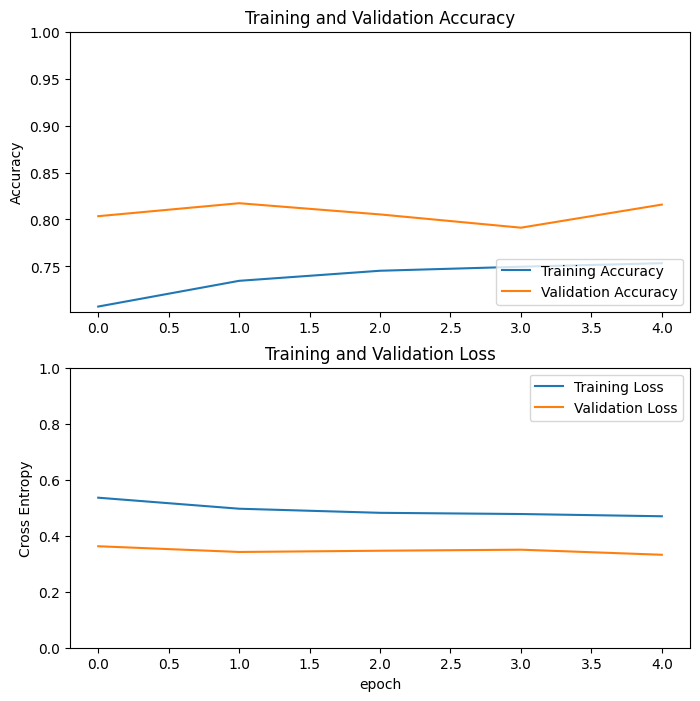

In [24]:
plot_model(history_2)

Finetuning

In [29]:
tf.keras.utils.plot_model(base_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [58]:
def unfreeze_model(model, lr, decay):
    print("Number of layers in the base model: ", len(base_model.layers))
    model.trainable = True
    set_trainable = False

    for layer in model.layers:
      if layer.name == 'block11wd_sepconv1_act':
          set_trainable = True
      if set_trainable:
          if not isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False
      else:
          layer.trainable = False

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [59]:
finetune_lr = 10 #@param {type:"slider", min:0, max:10000, step:100}
unfreeze_model(base_model, base_learning_rate/finetune_lr, decay)

model.summary()

Number of layers in the base model:  132
Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 1025)        2100225   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 1025)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 1025)        0         
                 

In [60]:
finetune_epochs = 20 # @param {type: "slider", min:1, max:30}
callback = get_callbacks("xc")
history_fine = model.fit(train_dataset_xc,
                    epochs=initial_epochs+finetune_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_dataset_xc,
                    callbacks=callback)

Epoch 10/30
2224/2225 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9278
Epoch 10: val_loss improved from inf to 0.15106, saving model to /notebooks/tmp_checkpoint/best_xc.h5
2225/2225 [==============================] - 323s 145ms/step - loss: 0.1658 - accuracy: 0.9279 - val_loss: 0.1511 - val_accuracy: 0.9436
Epoch 11/30
2224/2225 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9299
Epoch 11: val_loss improved from 0.15106 to 0.14418, saving model to /notebooks/tmp_checkpoint/best_xc.h5
2225/2225 [==============================] - 329s 148ms/step - loss: 0.1617 - accuracy: 0.9299 - val_loss: 0.1442 - val_accuracy: 0.9451
Epoch 12/30
2224/2225 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9302
Epoch 12: val_loss improved from 0.14418 to 0.14213, saving model to /notebooks/tmp_checkpoint/best_xc.h5
2225/2225 [==============================] - 335s 150ms/step - loss: 0.1605 - accuracy: 0.9302 - val_loss: 0.1421 -

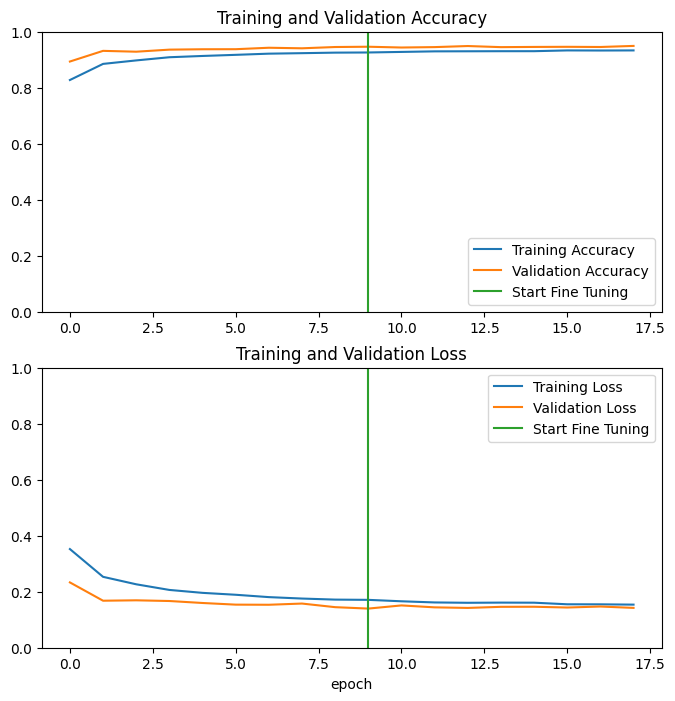

In [61]:
acc, val_acc, loss, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']
plot_fine(history_fine, acc, val_acc, loss, val_loss)

VGG 16
* A. Raza, K. Munir, und M. Almutairi, „A Novel Deep Learning Approach for Deepfake Image Detection“, Applied Sciences, Bd. 12, Nr. 19, S. 9820, Sep. 2022, doi: 10.3390/app12199820.


In [27]:
def create_model_vgg16(lr, decay):
    # Laden des Xception-Models (ohne den fully connected layer am Ende)
    base_model = tf.keras.applications.VGG16(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3))

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.vgg16.preprocess_input(inputs) #convert rgb to bgr
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    # training = False damit beim finetuning die batchnorm layers nicht geupdated werden
    x = base_model(x, training=False)

    #hinzufügen des klassifikations layers
    x = tf.keras.layers.Conv2D(1025, 1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.02) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1025, activation='relu')(x)

    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="VGG")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

In [28]:
base_learning_rate = 1e-2 # oder 1e-3 1e-4
decay = 1e-2
base_model, model = create_model_vgg16(base_learning_rate, decay)
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1025)        5258

Transfer Learning

In [37]:
loss0, accuracy0 = model.evaluate(val_dataset_vgg)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

301/301 [==============================] - 43s 125ms/step - loss: 0.6783 - accuracy: 0.5001
initial loss: 0.68
initial accuracy: 0.50


In [29]:
initial_epochs = 10 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history = model.fit(train_dataset_vgg,
                    epochs=initial_epochs,
                    validation_data=val_dataset_vgg,
                   callbacks=callback[0])

Epoch 1/10
2225/2225 [==============================] - 292s 129ms/step - loss: 0.2727 - accuracy: 0.8623 - val_loss: 0.1083 - val_accuracy: 0.9673
Epoch 2/10
2225/2225 [==============================] - 286s 128ms/step - loss: 0.1984 - accuracy: 0.9031 - val_loss: 0.0969 - val_accuracy: 0.9708
Epoch 3/10
2225/2225 [==============================] - 286s 128ms/step - loss: 0.1873 - accuracy: 0.9106 - val_loss: 0.0907 - val_accuracy: 0.9717
Epoch 4/10
2225/2225 [==============================] - 288s 129ms/step - loss: 0.1786 - accuracy: 0.9154 - val_loss: 0.0901 - val_accuracy: 0.9690
Epoch 5/10
2225/2225 [==============================] - 276s 124ms/step - loss: 0.1739 - accuracy: 0.9178 - val_loss: 0.0851 - val_accuracy: 0.9737
Epoch 6/10
2225/2225 [==============================] - 277s 124ms/step - loss: 0.1695 - accuracy: 0.9187 - val_loss: 0.0841 - val_accuracy: 0.9743
Epoch 7/10
2225/2225 [==============================] - 297s 133ms/step - loss: 0.1673 - accuracy: 0.9217 - val_

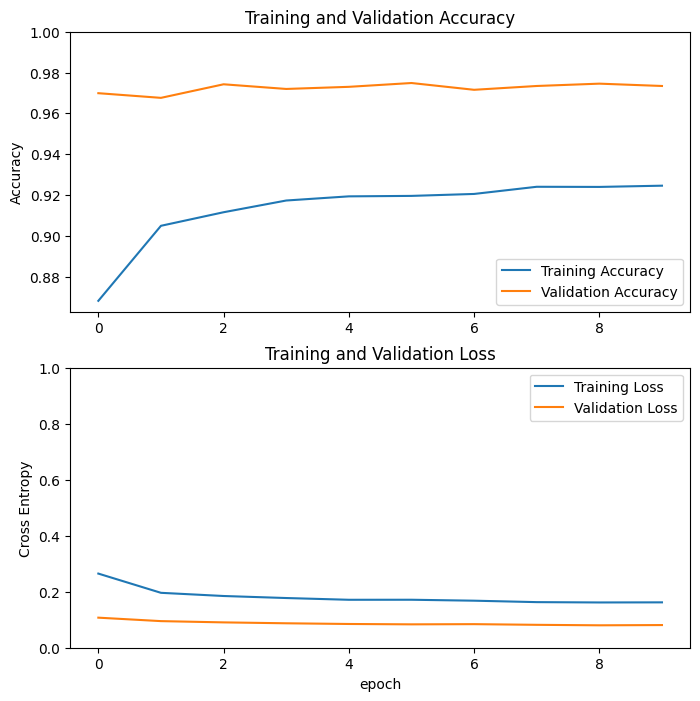

In [43]:
plot_model(history)

Architektur 2

In [25]:
def create_model_vgg16_2(lr, decay):
    # Laden des Xception-Models (ohne den fully connected layer am Ende)
    base_model = tf.keras.applications.VGG16(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3))

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.vgg16.preprocess_input(inputs) #convert rgb to bgr
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    # training = False damit beim finetuning die batchnorm layers nicht geupdated werden
    x = base_model(x, training=False)

    #hinzufügen des klassifikations layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5) (x)

    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="VGG16")
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

base_learning_rate = 1e-2 # oder 1e-3 1e-4
decay = 1e-2
base_model_2, model_2 = create_model_vgg16_2(base_learning_rate, decay)
model_2.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312 

In [26]:
initial_epochs = 5 # @param {type: "slider", min:1, max:30}
callback = get_callbacks()
history_2 = model_2.fit(train_dataset_vgg,
                    epochs=initial_epochs,
                    validation_data=val_dataset_vgg,
                   callbacks=callback[0])

Epoch 1/5
2225/2225 [==============================] - 317s 141ms/step - loss: 0.6652 - accuracy: 0.5640 - val_loss: 0.5935 - val_accuracy: 0.7538
Epoch 2/5
2225/2225 [==============================] - 318s 143ms/step - loss: 0.6460 - accuracy: 0.5877 - val_loss: 0.5837 - val_accuracy: 0.8188
Epoch 3/5
2225/2225 [==============================] - 319s 143ms/step - loss: 0.6385 - accuracy: 0.5957 - val_loss: 0.5726 - val_accuracy: 0.8331
Epoch 4/5
2225/2225 [==============================] - 319s 143ms/step - loss: 0.6359 - accuracy: 0.6015 - val_loss: 0.5585 - val_accuracy: 0.8287
Epoch 5/5
2225/2225 [==============================] - 320s 144ms/step - loss: 0.6316 - accuracy: 0.6076 - val_loss: 0.5543 - val_accuracy: 0.8370


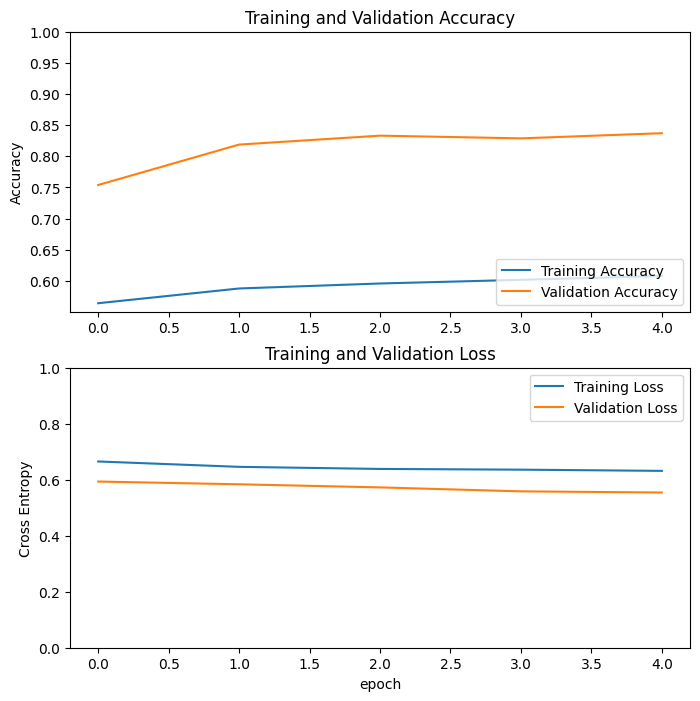

In [ ]:
plot_model(history_2)

Finetuning

In [44]:
tf.keras.utils.plot_model(base_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [49]:
def unfreeze_model(model, lr, decay):
    print("Number of layers in the base model: ", len(base_model.layers))
    model.trainable = True
    set_trainable = False

    for layer in model.layers:
      if layer.name == 'block5_conv1':
          set_trainable = True
      if set_trainable:
          if not isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False
      else:
          layer.trainable = False

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [50]:
finetune_lr = 10 #@param {type:"slider", min:0, max:10000, step:100}
unfreeze_model(base_model, base_learning_rate/finetune_lr, decay)

model.summary()

Number of layers in the base model:  19
Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)

In [51]:
finetune_epochs = 20 # @param {type: "slider", min:1, max:30}
callback = get_callbacks("vgg")
history_fine = model.fit(train_dataset_vgg,
                    epochs=initial_epochs+finetune_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_dataset_vgg,
                    callbacks=callback)

Epoch 10/30
2225/2225 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9250
Epoch 10: val_loss improved from inf to 0.07905, saving model to /notebooks/tmp_checkpoint/best_vgg.h5
2225/2225 [==============================] - 332s 149ms/step - loss: 0.1595 - accuracy: 0.9250 - val_loss: 0.0791 - val_accuracy: 0.9746
Epoch 11/30
2225/2225 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9259
Epoch 11: val_loss improved from 0.07905 to 0.07880, saving model to /notebooks/tmp_checkpoint/best_vgg.h5
2225/2225 [==============================] - 337s 151ms/step - loss: 0.1572 - accuracy: 0.9259 - val_loss: 0.0788 - val_accuracy: 0.9749
Epoch 12/30
2225/2225 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9269
Epoch 12: val_loss did not improve from 0.07880
2225/2225 [==============================] - 338s 151ms/step - loss: 0.1567 - accuracy: 0.9269 - val_loss: 0.0790 - val_accuracy: 0.9742
Epoch 13/30
2225/2225 [===========

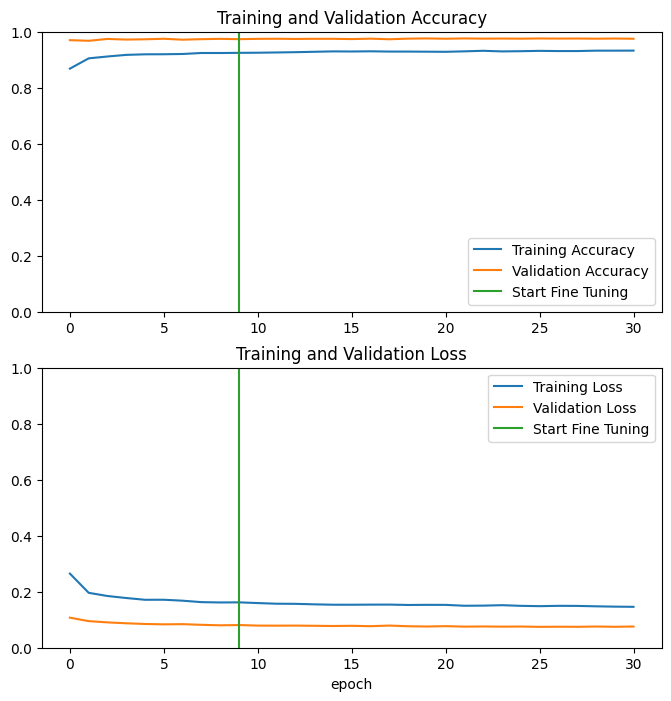

In [52]:
acc, val_acc, loss, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']
plot_fine(history_fine, acc, val_acc, loss, val_loss)

In [ ]:
model.save('saved_models/my_vgg')